In [1]:
# Import necessary libraries
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


In [2]:
# Load your dataset
file_name = 'reshaped_counties_by_year.csv'  # Update with your actual file path if necessary
data = pd.read_csv(file_name)

# Display the first few rows of the dataset to confirm it's loaded correctly
# print(data.head())


In [3]:
# Check the shape of the dataset
print("Dataset Shape:", data.shape)

# Display the column names
print("Columns:", data.columns)

# Display data types of each column
print("Data Types:\n", data.dtypes)

# Get basic statistics of the dataset
print("Basic Statistics:\n", data.describe())

# Check for any missing values
print("Missing Values:\n", data.isnull().sum())


Dataset Shape: (1104, 7)
Columns: Index(['GeoName', 'Year', 'All industry total',
       'Personal income (thousands of dollars)', 'Population (persons) 3/',
       'Total employment', 'Wages and salaries'],
      dtype='object')
Data Types:
 GeoName                                    object
Year                                        int64
All industry total                        float64
Personal income (thousands of dollars)    float64
Population (persons) 3/                   float64
Total employment                          float64
Wages and salaries                        float64
dtype: object
Basic Statistics:
               Year  All industry total  \
count  1104.000000         1104.000000   
mean   2015.500000            0.040171   
std       3.453617            0.110543   
min    2010.000000            0.000000   
25%    2012.750000            0.005971   
50%    2015.500000            0.013510   
75%    2018.250000            0.030130   
max    2021.000000            1.000000

In [4]:
def filter_county_data(data, county_name):
    """Filter the dataset for a specific county."""
    county_data = data[data['GeoName'] == county_name]
    return county_data

# Example usage for Adams County
county_name = 'Adams, IN'
adams_data = filter_county_data(data, county_name)

# Display the filtered data
print(adams_data)


        GeoName  Year  All industry total  \
0     Adams, IN  2010            0.011770   
92    Adams, IN  2011            0.012597   
184   Adams, IN  2012            0.013479   
276   Adams, IN  2013            0.014540   
368   Adams, IN  2014            0.015336   
460   Adams, IN  2015            0.016742   
552   Adams, IN  2016            0.016692   
644   Adams, IN  2017            0.018078   
736   Adams, IN  2018            0.017459   
828   Adams, IN  2019            0.018011   
920   Adams, IN  2020            0.017035   
1012  Adams, IN  2021            0.017755   

      Personal income (thousands of dollars)  Population (persons) 3/  \
0                                   0.020184                 0.031551   
92                                  0.021068                 0.031231   
184                                 0.022453                 0.030932   
276                                 0.023994                 0.030892   
368                                 0.024244     

In [5]:
from statsmodels.tsa.stattools import adfuller

# Set 'Year' as the index
adams_data.set_index('Year', inplace=True)

# Select the metric for ARIMA (Personal income)
time_series_data = adams_data['Personal income (thousands of dollars)']

# Check for stationarity using the Augmented Dickey-Fuller test
adf_result = adfuller(time_series_data)

# Print the ADF statistic and p-value
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Interpret the p-value
if adf_result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ADF Statistic: 0.4820801658588702
p-value: 0.9843181392189152
The time series is not stationary.


In [6]:
# Apply first differencing
differenced_data = time_series_data.diff().dropna()

# Check for stationarity again using the ADF test
adf_result_diff = adfuller(differenced_data)

# Print the ADF statistic and p-value for the differenced data
print('ADF Statistic (Differenced):', adf_result_diff[0])
print('p-value (Differenced):', adf_result_diff[1])

# Interpret the p-value for differenced data
if adf_result_diff[1] <= 0.05:
    print("The differenced time series is stationary.")
else:
    print("The differenced time series is still not stationary.")


ADF Statistic (Differenced): -4.18296746795739
p-value (Differenced): 0.0007040349110071187
The differenced time series is stationary.


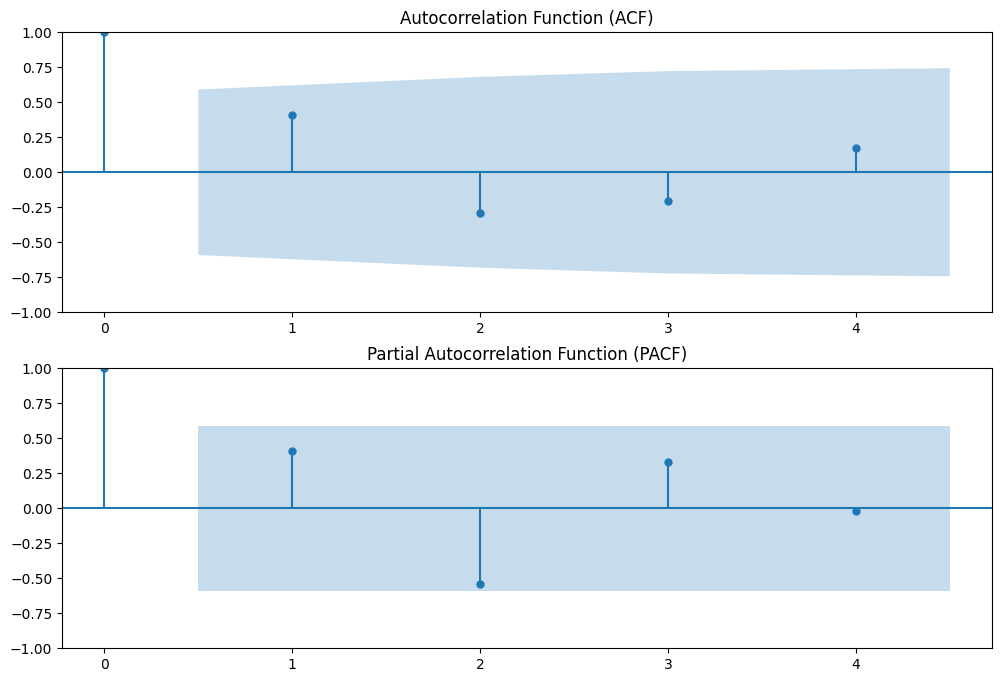

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF with a maximum of 4 lags
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(differenced_data, ax=ax[0], lags=4)
ax[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(differenced_data, ax=ax[1], lags=4)
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()


In [8]:
from sklearn.preprocessing import LabelEncoder

# Assuming your dataset is named 'df', replace with the actual variable if it's different
label_encoder = LabelEncoder()

# Encode the GeoName column (counties)
data['GeoName_encoded'] = label_encoder.fit_transform(data['GeoName'])

# Check the new column
print(data[['GeoName', 'GeoName_encoded']].head())


           GeoName  GeoName_encoded
0        Adams, IN                0
1        Allen, IN                1
2  Bartholomew, IN                2
3       Benton, IN                3
4    Blackford, IN                4


In [9]:
# !pip install pmdarima

In [10]:
from pmdarima import auto_arima

# Function to train models for each county
def train_arima_models(data):
    county_models = {}
    counties = data['GeoName'].unique()

    for county in counties:
        county_data = data[data['GeoName'] == county].set_index('Year')
        
        # Use auto_arima to find the best ARIMA parameters
        model = auto_arima(county_data['All industry total'], seasonal=False, stepwise=True, trace=True)
        county_models[county] = model

    return county_models



# Train the models
models = train_arima_models(data)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-118.337, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-63.292, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-128.425, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-101.865, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-122.748, Time=0.23 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-120.006, Time=0.14 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-125.820, Time=0.25 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.686 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0

C:\Users\91903\anaconda3\envs\py311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-129.604, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-82.588, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-139.623, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-125.172, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-148.943, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-135.287, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-143.911, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-147.829, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-133.934, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-137.288, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-133.288, Time=0.13 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-149.595, Time=0.10 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-148.162, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[

In [11]:
from scipy.stats import jarque_bera

# Function to perform Jarque-Bera test on residuals for each county model
def test_jarque_bera_on_models(models, data):
    jb_test_results = {}

    counties = data['GeoName'].unique()

    for county in counties:
        model = models[county]  # Get the trained model for the county

        # Get the residuals from the model
        residuals = model.resid()

        # Perform the Jarque-Bera test on the residuals
        jb_stat, jb_p_value = jarque_bera(residuals)
        jb_test_results[county] = {'JB Stat': jb_stat, 'p-value': jb_p_value}

        # Print the Jarque-Bera test results for the current county
        print(f"Jarque-Bera test results for {county}:")
        print(f"  - JB Stat: {jb_stat}")
        print(f"  - p-value: {jb_p_value}\n")

    return jb_test_results

# Step 1: Train the models
models = train_arima_models(data)

# Step 2: Test the models with Jarque-Bera
jb_test_results = test_jarque_bera_on_models(models, data)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-118.337, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-63.292, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-128.425, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-101.865, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-122.748, Time=0.29 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-120.006, Time=0.18 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-125.820, Time=0.27 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.829 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,0

C:\Users\91903\anaconda3\envs\py311\Lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-129.604, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-82.588, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-139.623, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-125.172, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-148.943, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-135.287, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-143.911, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-147.829, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-133.934, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-137.288, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-133.288, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-149.595, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-148.162, Time=0.15 sec
 ARIMA(3,0,1)(0,0,0)[

In [12]:
# Function to predict for a specific county

def predict_growth(county_name, models, periods=1):
    model = models[county_name]
    forecast, conf_int = model.predict(n_periods=periods, return_conf_int=True)
    return forecast, conf_int

# Example prediction for "Adams, IN"
forecast, conf_int = predict_growth("Vigo, IN", models)
print(f"Predicted growth for Floyd, IN: {forecast}")


Predicted growth for Floyd, IN: 12    0.048709
dtype: float64


C:\Users\91903\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\91903\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [13]:
# Predict growth for the next 13 months to include January 2023
forecast_13, conf_int_13 = predict_growth("Vigo, IN", models, periods=13)

# Print the predicted growth for January 2023
print(f"Predicted growth for Vigo, IN for 2023: {forecast_13.iloc[12]}")


Predicted growth for Vigo, IN for 2023: 0.05099718763366579


C:\Users\91903\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\91903\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
import pandas as pd

# Load the CSV file
reshaped_counties_by_year = pd.read_csv('reshaped_counties_by_year.csv')

# Filter the data for the year 2021 for the specific county
filtered_2021 = reshaped_counties_by_year[(reshaped_counties_by_year['GeoName'] == 'Vigo, IN') & (reshaped_counties_by_year['Year'] == 2021)]

# Extract the value for 'All industry total' for the year 2021
value_2021 = filtered_2021['All industry total']

# Check if value_2021 is a Series and extract the actual value
if isinstance(value_2021, pd.Series):
    value_2021 = value_2021.iloc[0]

# print("Filtered data for 2021:", filtered_2021)
# print("Extracted value_2021:", value_2021)

# Extract the forecasted value for 2022 from the variable 'forecast'
# Assuming forecast looks like: 12    0.003909
forecast = pd.Series([12,0.048709])  # Example structure, replace with actual 'forecast' data
value_2022 = forecast.iloc[1]  # Get the second element

# print("Extracted value_2022:", value_2022)

# Now that both value_2021 and value_2022 are scalars, calculate the percentage increase
if value_2021 is not None and value_2022 is not None:
    percentage_increase = ((value_2022 - value_2021) / value_2021) * 100
    print(f"Percentage Increase from 2021 to 2022: {percentage_increase:.2f}%")
else:
    print("Error: Missing values for calculation!")


Percentage Increase from 2021 to 2022: 2.82%


In [15]:
import pandas as pd

# Assuming you have already defined the forecast for 2022
forecast_2022 = pd.Series([12, 0.048709])  # Example structure, replace with actual forecast data
value_2022_forecasted = forecast_2022.iloc[1]  # Get the forecasted value for 2022

# Forecast for the next 13 months to include January 2023
forecast_13, _ = predict_growth("Vigo, IN", models, periods=13)

# Get the forecasted value for January 2023 (the 13th period)
value_2023_forecasted = forecast_13.iloc[12]  # January 2023

# Calculate the percentage increase from 2022 to 2023
if value_2022_forecasted is not None and value_2023_forecasted is not None:
    percentage_increase_2022_to_2023 = ((value_2023_forecasted - value_2022_forecasted) / value_2022_forecasted) * 100
    print(f"Percentage Increase from 2022 to 2023: {percentage_increase_2022_to_2023:.2f}%")
else:
    print("Error: Missing values for calculation!")


Percentage Increase from 2022 to 2023: 4.70%


C:\Users\91903\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\91903\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


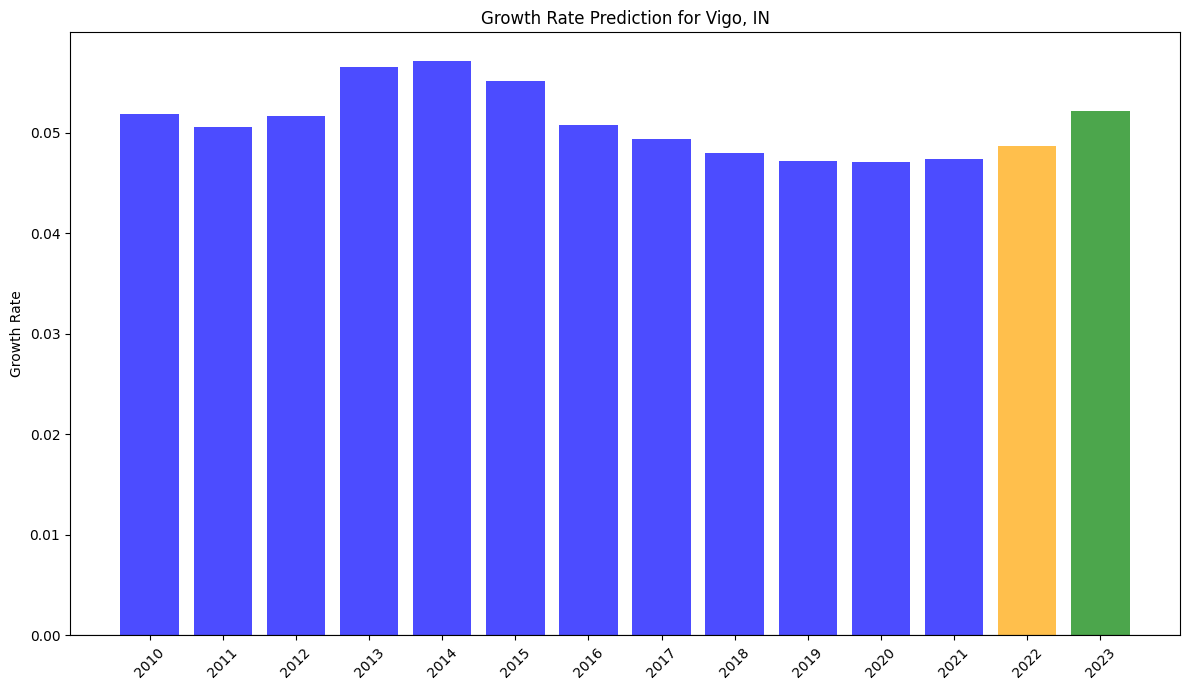

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv('reshaped_counties_by_year.csv')

# Specify the county name you're interested in
county_name = 'Vigo, IN'  # Change this to the specific county name

# Extract data for the specified county
county_data = data[data['GeoName'] == county_name]

# Extract years and values for All industry total
years = list(range(2010, 2022))  # Years from 2010 to 2021
actual_values = county_data[['Year', 'All industry total']].set_index('Year').loc[years].values.flatten()

# Add the predicted values for 2022 and 2023
predicted_value_2022 = 0.048709  # Replace with your actual predicted value for 2022
predicted_value_2023 = 0.052134  # Replace with your actual predicted value for 2023 (example value)

# Combine years and values, including the predictions
combined_years = years + [2022, 2023]
combined_values = list(actual_values) + [predicted_value_2022, predicted_value_2023]

# Plotting
plt.figure(figsize=(12, 7))
plt.bar(combined_years, combined_values, color=['blue'] * len(years) + ['orange', 'green'], alpha=0.7)
plt.xticks(combined_years, rotation=45)  # Rotate x-axis labels for better readability
plt.ylabel('Growth Rate')
plt.title(f'Growth Rate Prediction for {county_name}')
plt.axhline(0, color='black', lw=0.8)  # Add a horizontal line at y=0

# Optional: Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
